In [1]:
import sys
import glob
import csv
import numpy as np
import matplotlib.pyplot as ppt
%matplotlib inline

CAFFE_ROOT = '/home/chrisbot/Projects/caffe'
DATASET_TYPE = 'imagenet' # imagenet, gtsrb or coil
#AE_ROOTS = ['/media/sf_Masterarbeit/data/AE/GTSRB_TRAIN_PREPROCESSED_AE_0.005',
#            '/media/sf_Masterarbeit/data/AE/GTSRB_TRAIN_PREPROCESSED_AE_0.025',
#            '/media/sf_Masterarbeit/data/AE/GTSRB_TRAIN_PREPROCESSED_AE_0.037',
#            '/media/sf_Masterarbeit/data/AE/GTSRB_TRAIN_PREPROCESSED_AE_0.05']
AE_ROOTS = ['/media/sf_Masterarbeit/data/AE/ILSVRC2012_AE_50']
SAVE_PATH = '/media/sf_Masterarbeit/master-thesis/report/images/confusion-matrices/imagenet-ae-50.png'

# Function to get display name for a class.
import adex
import adex.googlenet

imagenet_labels = adex.googlenet.load_labels(CAFFE_ROOT)

if DATASET_TYPE == 'imagenet':
    display_name_fetcher = lambda x: imagenet_labels[int(x)][1]
elif DATASET_TYPE == 'gtsrb':
    display_name_fetcher = lambda x: '{0:05d}'.format(int(x))
else:
    display_name_fetcher = lambda x: x

In [2]:
original_classes = set()
target_classes = set()

for ae_root in AE_ROOTS:
    for csv_path in glob.glob(ae_root + '/*.csv'):
        with open(csv_path) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                if row['SourceClass'] not in original_classes:
                    original_classes.add(row['SourceClass'])
                if row['TargetClass'] not in target_classes:
                    target_classes.add(row['TargetClass'])

#Make sure all common classes are at the front and have the same index
all_classes = sorted(original_classes & target_classes, key=lambda x: int(x))
ocl = all_classes[:] + list(original_classes - target_classes)
tcl = all_classes[:] + list(target_classes - original_classes)
original_classes = ocl
target_classes = tcl

sys.stdout.write('Found {0} original classes\n'.format(len(original_classes)))
sys.stdout.write('Found {0} target classes'.format(len(target_classes)))
sys.stdout.flush()

Found 50 original classes
Found 50 target classes

In [3]:
confusion_matrix = np.zeros((len(original_classes), len(target_classes), 2))

for ae_root in AE_ROOTS:
    #for csv_path in glob.glob(AE_ROOT + '/*.csv'):
    for csv_path in glob.glob(ae_root + '/*.csv'):
        with open(csv_path) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                orig_class_idx = original_classes.index(row['SourceClass'])
                target_class_idx = target_classes.index(row['TargetClass'])
                confusion_matrix[orig_class_idx, target_class_idx, :] += [float(row['Confidence']), 1]

confusion_matrix = confusion_matrix[..., 0] / confusion_matrix[..., 1]
print('Confusion matrix computed, range: {0} - {1}'.format(np.min(confusion_matrix), np.max(confusion_matrix)))

Confusion matrix computed, range: 2.97109e-08 - 0.999999


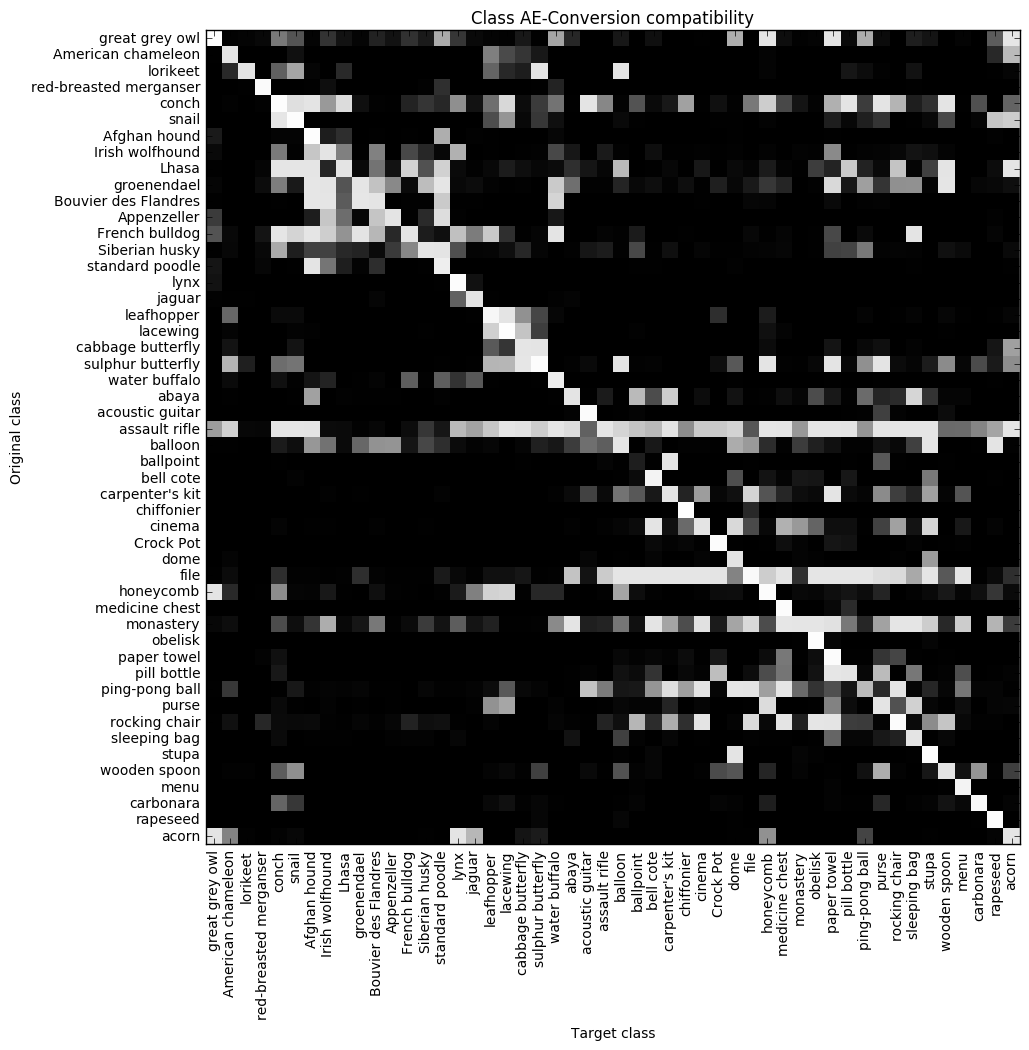

In [4]:
original_classes = map(display_name_fetcher, original_classes)
target_classes = map(display_name_fetcher, target_classes)

ppt.imshow(confusion_matrix, cmap=ppt.cm.gray, interpolation='none')
ppt.title('Class AE-Conversion compatibility')
ppt.xlabel('Target class')
ppt.ylabel('Original class')
ppt.xticks(np.arange(len(original_classes)), original_classes, rotation=90)
ppt.yticks(np.arange(len(target_classes)), target_classes)
fig = ppt.gcf()
fig.set_size_inches(18.5, 10.5)

fig.savefig(SAVE_PATH, bbox_inches='tight')